<a href="https://colab.research.google.com/github/capozzolicaluan/TiltmeterAnalysis/blob/main/Tiltimeter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [333]:
# import drive from colab
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [334]:
# import packages
import pandas as pd
from google.colab  import files
import io
from io import StringIO
import matplotlib.pyplot as plt
from datetime import datetime
import os

In [335]:
# functions
def list_folders(directory_path):

  # List folders in the directory
  folders = [f for f in os.listdir(directory) if os.path.isdir(os.path.join(directory, f))]

  return(folders)

def list_files(file_directory):
  # list files in specific directory
  files = [f for f in os.listdir(file_directory) if os.path.isfile(os.path.join(file_directory, f))]

  return(files)

def read_tilt_data(directory_file, tilt_files_list):
  file_path_one = "{}/{}".format(directory_file, tilt_files_list[0])
  file_path_two = "{}/{}".format(directory_file, tilt_files_list[1])

  axis_one = pd.read_csv((file_path_one), parse_dates=True, delimiter = ',',engine='c')
  axis_one = axis_one['Sample Date / Time,"Location","Sensor","Value","OB Temp"'].str.split(',', expand=True)
  axis_one = axis_one.apply(lambda x: x.str.strip('"'))
  axis_one.columns = ['Sample Date / Time', 'Location', 'Sensor', 'Value', 'OB Temp']

  axis_two = pd.read_csv((file_path_two), parse_dates=True, delimiter = ',',engine='c')
  axis_two = axis_two['Sample Date / Time,"Location","Sensor","Value","OB Temp"'].str.split(',', expand=True)
  axis_two = axis_two.apply(lambda x: x.str.strip('"'))
  axis_two.columns = ['Sample Date / Time', 'Location', 'Sensor', 'Value', 'OB Temp']

  # convert date-time format
  axis_one['Sample Date / Time'] = axis_one['Sample Date / Time'].apply(convert_date_format)
  axis_two['Sample Date / Time'] = axis_two['Sample Date / Time'].apply(convert_date_format)

  # convert date-time column to datetime type
  axis_one['Sample Date / Time'] = pd.to_datetime(axis_one['Sample Date / Time'])
  axis_two['Sample Date / Time'] = pd.to_datetime(axis_two['Sample Date / Time'])

  # Definir a coluna 'datetime_column' como o índice do DataFrame
  axis_one.set_index('Sample Date / Time', inplace=True)
  axis_two.set_index('Sample Date / Time', inplace=True)

  tilt_data['Date-time'] = axis_one.index
  tilt_data.set_index('Date-time', inplace = True)
  tilt_data['Date-time'] = tilt_data.index
  tilt_data['Tilt_axis_one'] = axis_one['Value']
  tilt_data['Tilt_axis_two'] = axis_two['Value']


  return(tilt_data)

In [336]:
# 3. Adicionar o diretório ao sys.path
import sys
sys.path.append('/content/drive/MyDrive/Colab/TiltmetersAnalysis/functions/')

# 4. Importar e usar o módulo
import functions_module

In [337]:
# Path to data directory
directory = '/content/drive/MyDrive/Colab/TiltmetersAnalysis/data'

# List folders in the directory
folders = list_folders(directory_path = directory)

# files in the folder
files = list_files(file_directory = "{}/{}/".format(directory,folders[0]))

In [338]:
directory_path = "{}/{}/".format(directory,folders[0])
directory_path

'/content/drive/MyDrive/Colab/TiltmetersAnalysis/data/18c6/'

In [339]:
directory_file = directory_path
tilt_files_list = files

In [340]:
directory_path

'/content/drive/MyDrive/Colab/TiltmetersAnalysis/data/18c6/'

In [341]:
files

['EIXO_X.csv', 'EIXO_Z.csv', 'TEMPERATURA.csv']

In [342]:
axis_ = read_tilt_data(directory_file = directory_path, tilt_files_list = files)

In [343]:
axis_

,Tilt_axis_one,Tilt_axis_two,Date-time
Date-time,,,
2023-07-07 09:05:18,0.0000,0.0000,2023-07-07 09:05:18
2023-07-07 09:10:18,-0.0003,0.0004,2023-07-07 09:10:18
2023-07-07 09:20:18,-0.0005,-0.0007,2023-07-07 09:20:18
2023-07-07 10:40:27,-0.0029,-0.0037,2023-07-07 10:40:27
2023-07-07 10:50:18,-0.0028,-0.0061,2023-07-07 10:50:18
...,...,...,...
2024-04-11 11:00:29,0.0044,-0.0038,2024-04-11 11:00:29
2024-04-11 12:00:29,0.0046,-0.0049,2024-04-11 12:00:29
2024-04-11 12:30:29,0.0046,-0.0057,2024-04-11 12:30:29


In [ ]:
# remove instalation outliers
mask = (dataX['Tilt'] > 10)
dataX = dataX.loc[~mask]

In [ ]:
# diff between lines
dataX['Tilt Difference'] = dataX.Tilt.diff()
dataX['Temp Difference'] = dataX.Temperature.diff()

# save index as column
time_series = pd.DataFrame()
time_series['date-time'] = dataX.index
time_series.set_index(dataX.index, inplace=True)

<ipython-input-7-9a7715034e6f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataX['Tilt Difference'] = dataX.Tilt.diff()
<ipython-input-7-9a7715034e6f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataX['Temp Difference'] = dataX.Temperature.diff()


In [ ]:
# difference between times
time_series['delta_time'] = time_series.diff()

# NaT by date
time_series['delta_time'] = time_series['delta_time'].fillna(pd.Timedelta(seconds=0))

# column with delta time in hours
time_series['delta_time_hours'] = time_series['delta_time'].dt.total_seconds()/3600

In [ ]:
dataX['Velocity'] = dataX['Tilt Difference'] / time_series['delta_time_hours']
dataX['Velocity'][0] = 0
dataX['Temp Difference'][0] = 0
dataX['Tilt Difference'][0] = 0

<ipython-input-9-358adb920de7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataX['Velocity'] = dataX['Tilt Difference'] / time_series['delta_time_hours']
<ipython-input-9-358adb920de7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataX['Velocity'][0] = 0
<ipython-input-9-358adb920de7>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataX['Temp Difference'][0] = 0
<ipyth

In [ ]:
dataX['Aceleration'] = dataX.Velocity.diff()/time_series['delta_time_hours']
dataX['Aceleration'][0] = 0

<ipython-input-10-606631767324>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataX['Aceleration'] = dataX.Velocity.diff()/time_series['delta_time_hours']
<ipython-input-10-606631767324>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataX['Aceleration'][0] = 0


In [ ]:
# remove os na's
dataX = dataX.dropna()

In [ ]:
# estatisticas basicas dos dados
dataX.describe()

,Tilt,Temperature,Tilt Difference,Temp Difference,Velocity,Aceleration
count,19688.000000,19688.000000,1.968800e+04,19688.000000,19688.000000,19688.000000
mean,0.000495,21.372747,8.634701e-08,-0.000024,-0.000133,0.096997
std,0.002607,4.632346,5.011700e-04,0.623821,0.009443,18.753125
min,-0.008300,9.120000,-7.000000e-03,-7.310000,-0.216000,-79.488000
25%,-0.001400,17.860000,-3.000000e-04,-0.310000,-0.002400,-0.043200
50%,0.000400,20.880000,0.000000e+00,0.000000,0.000000,0.000000
75%,0.002400,24.530000,3.000000e-04,0.160000,0.002400,0.043200
max,0.009100,38.670000,5.700000e-03,11.760000,0.720000,2621.793103


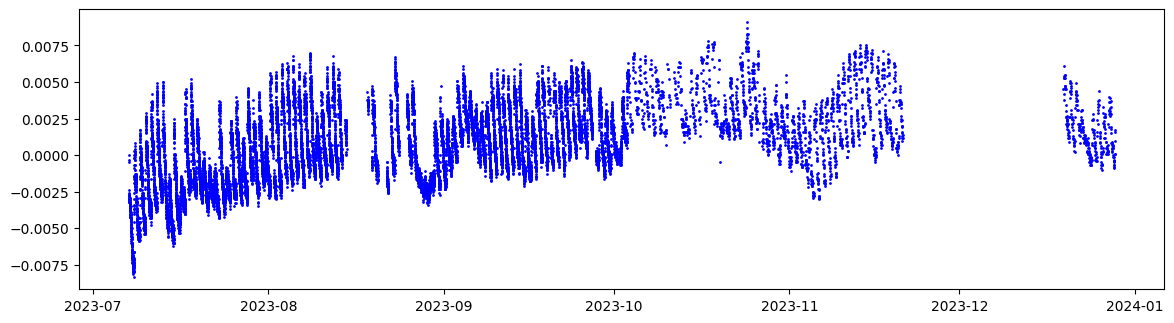

In [ ]:
plt.figure(figsize = ((14, 8)))

plt.subplot(2, 1, 1)

# Plotar a média diária com barras de erro para desvio padrão e sombras para máximos e mínimos
#plt.figure(figsize=(16, 6))

#plt.plot(daily_stats.index, daily_stats['mean'], label='Média Diária', color='blue')
plt.plot(dataX.index, dataX['Tilt'], 'o', color='blue', label='Média Diária', markersize = 1)

In [ ]:
# daily stats
daily_stats_temp = dataX.Temperature.resample('D').agg(['mean', 'std', 'min', 'max'])
daily_stats_tilt = dataX.Tilt.resample('D').agg(['mean', 'std', 'min', 'max'])
daily_stats_veloc = dataX.Velocity.resample('D').agg(['mean', 'std', 'min', 'max'])
daily_stats_acel = dataX.Aceleration.resample('D').agg(['mean', 'std', 'min','max'])

In [ ]:
# removing first day, once start with zero
daily_stats_temp = daily_stats_temp.iloc[2:,:]
daily_stats_tilt = daily_stats_tilt.iloc[2:,:]
daily_stats_veloc = daily_stats_veloc.iloc[2:,:]
daily_stats_acel = daily_stats_acel.iloc[2:,:]

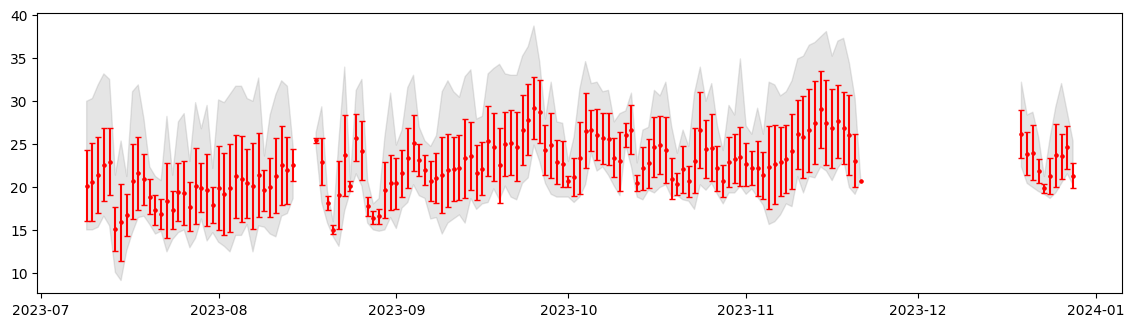

In [ ]:
plt.figure(figsize = ((14, 8)))

plt.subplot(2, 1, 1)

# Plotar a média diária com barras de erro para desvio padrão e sombras para máximos e mínimos
#plt.figure(figsize=(16, 6))

#plt.plot(daily_stats.index, daily_stats['mean'], label='Média Diária', color='blue')
plt.plot(daily_stats_temp.index, daily_stats_temp['mean'], 'o', color='red', label='Média Diária', markersize = 2)

# Adicionar barras de erro para desvio padrão
plt.errorbar(daily_stats_temp.index, daily_stats_temp['mean'], yerr=daily_stats_temp['std'], fmt='o', color='red', label='Desvio Padrão', capsize = 2, markersize = 2)

# Adicionar sombra para valores máximo e mínimo
plt.fill_between(daily_stats_temp.index, daily_stats_temp['min'], daily_stats_temp['max'], color='gray', alpha=0.2, label='Máximo e Mínimo')

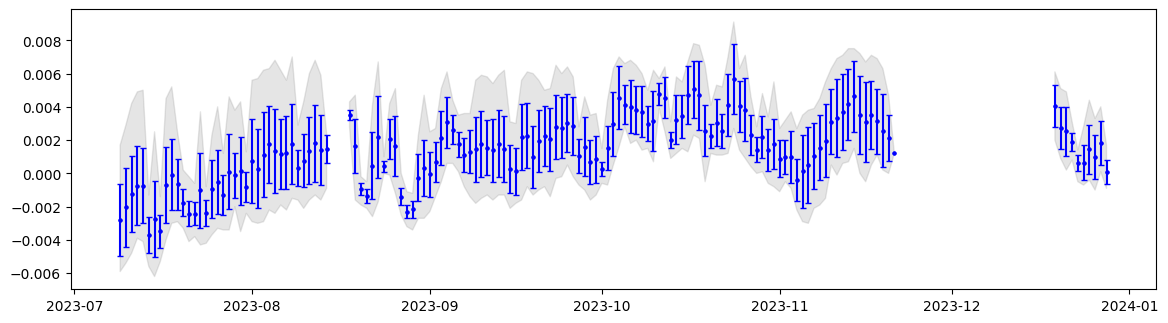

In [ ]:
plt.figure(figsize = ((14, 8)))
# Plotar a média diária com barras de erro para desvio padrão e sombras para máximos e mínimos
plt.subplot(2, 1, 2)

# plotar as médias
plt.plot(daily_stats_tilt.index, daily_stats_tilt['mean'], 'o', color='blue', label='Média Diária', markersize = 2)

# Adicionar barras de erro para desvio padrão
plt.errorbar(daily_stats_tilt.index, daily_stats_tilt['mean'], yerr=daily_stats_tilt['std'], fmt='o', color='blue', label='Desvio Padrão', capsize = 2, markersize = 2)

# Adicionar sombra para valores máximo e mínimo
plt.fill_between(daily_stats_tilt.index, daily_stats_tilt['min'], daily_stats_tilt['max'], color='gray', alpha=0.2, label='Máximo e Mínimo')

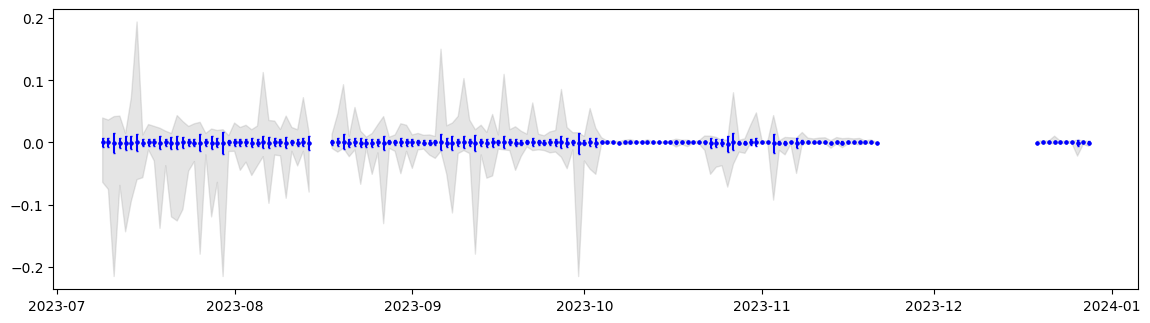

In [ ]:
plt.figure(figsize = ((14, 8)))
# Plotar a média diária com barras de erro para desvio padrão e sombras para máximos e mínimos
plt.subplot(2, 1, 2)

# plotar as médias
plt.plot(daily_stats_veloc.index, daily_stats_veloc['mean'], 'o', color='blue', label='Média Diária', markersize=2)

# Adicionar barras de erro para desvio padrão
plt.errorbar(daily_stats_veloc.index, daily_stats_veloc['mean'], yerr=daily_stats_veloc['std'], fmt='o', color='blue', label='Desvio Padrão', capsize = 0.5, markersize= 2)

# Adicionar sombra para valores máximo e mínimo
plt.fill_between(daily_stats_veloc.index, daily_stats_veloc['min'], daily_stats_veloc['max'], color='gray', alpha=0.2, label='Máximo e Mínimo')

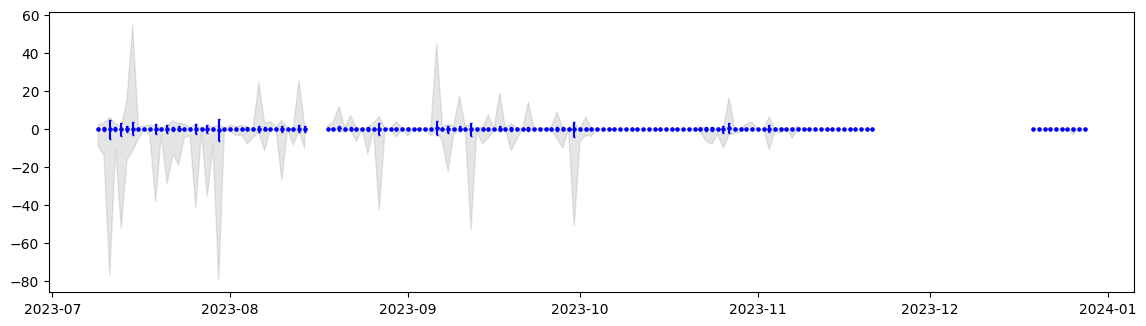

In [ ]:
plt.figure(figsize = ((14, 8)))
# Plotar a média diária com barras de erro para desvio padrão e sombras para máximos e mínimos
plt.subplot(2, 1, 2)

# plotar as médias
plt.plot(daily_stats_acel.index, daily_stats_acel['mean'], 'o', color='blue', label='Média Diária', markersize=2)

# Adicionar barras de erro para desvio padrão
plt.errorbar(daily_stats_acel.index, daily_stats_acel['mean'], yerr=daily_stats_acel['std'], fmt='o', color='blue', label='Desvio Padrão', capsize = 0.5, markersize= 2)

# Adicionar sombra para valores máximo e mínimo
plt.fill_between(daily_stats_acel.index, daily_stats_acel['min'], daily_stats_acel['max'], color='gray', alpha=0.2, label='Máximo e Mínimo')